# GCCR002: COVID prediction from GCCR data

In [1]:
# Imports
#%load_ext lab_black
%load_ext autoreload
%autoreload 2
from gccr002 import *
import figures
import tables
import time

start = time.time()

# Figure styles
sns.set_style("whitegrid")
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

figures.SAVE = False
tables.SAVE = False

### Load the pre-processed data and diagnosis classes (see pre-analysis notebook)

In [2]:
# All of the content loaded here was produced in pre-analysis.ipynb
df, Xu, Xn, dtypes, s, classes = load_all()
original_cols = list(df)

In [3]:
# A universal cross-validation splitter
sh_split = ShuffleSplit(100, random_state=0)

In [81]:
# All 4
diagnoses = {
    "C19+": s["lab-covid"],
    "C19+ (Clinical)": s["clinical-covid"],
    "Unknown": s["unknown-covid"],
    "C19-": s["non-covid"],
}

# Only Lab + and Clinical +
diagnoses["plus"] = {key: diagnoses[key] for key in diagnoses if "+" in key}

# All but unknown
diagnoses["known"] = {
    key: diagnoses[key] for key in diagnoses if "+" in key or "-" in key
}

# Only Lab + and Lab -
diagnoses["clean"] = {
    key: diagnoses[key] for key in diagnoses if len(key) == 4 and "C19" in key
}

# Quick COVID status lookup (not to be placed in X)
df = status_map(df, diagnoses, "COVID Status (All)")
df = status_map(df, diagnoses["clean"], "COVID Status")

features = list(
    chain(
        *[
            classes["features"][kind]
            for kind in ["chemosensory", "typical", "history", "demographic"]
        ]
    )
)
senses = colors.index.get_level_values("sense").unique()
X = Xn.loc[s["lab-covid"] | s["non-covid"], features].sort_index()
y = X.index.to_series().isin(s["lab-covid"])
sample_weight = None

lr = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    C=10,
    l1_ratio=1,
    max_iter=10000,
    random_state=0,
)

lrcv = LogisticRegressionCV(
    penalty="elasticnet",
    solver="saga",
    Cs=[10],
    n_jobs=sh_split.n_splits,
    l1_ratios=[1],
    max_iter=10000,
    random_state=0,
    cv=sh_split,
    scoring="roc_auc",
)

s["no_chem_or_block"] = get_set(
    df, "Chemesthesis_during_illness < 20 & Blocked_nose_during_illness < 20"
)
s["no_chem_but_block"] = get_set(
    df, "Chemesthesis_during_illness < 20 & Blocked_nose_during_illness >= 20"
)
s["chem_no_block"] = get_set(
    df, "Chemesthesis_during_illness >= 20 & Blocked_nose_during_illness < 20"
)
s["chem_and_block"] = get_set(
    df, "Chemesthesis_during_illness >= 20 & Blocked_nose_during_illness >= 20"
)

### Figure 2

Smell (during): C19+ = 8.97 +/- 20.8; C19- = 28.8 +/- 33.5; p=1.08e-59
Smell (change): C19+ = -82.4 +/- 27.2; C19- = -59.8 +/- 37.7; p=2.23e-46
Taste (during): C19+ = 21.1 +/- 27.9; C19- = 34.4 +/- 33.5; p=7.08e-24
Taste (change): C19+ = -71.6 +/- 31.8; C19- = -55.2 +/- 37.5; p=6.71e-26
Chemesthesis (during): C19+ = 44.4 +/- 32.2; C19- = 50.2 +/- 31.5; p=4.57e-05
Chemesthesis (change): C19+ = -36.8 +/- 37.1; C19- = -28.7 +/- 37.1; p=2.45e-07
Blocked Nose (during): C19+ = 35 +/- 32; C19- = 37.8 +/- 32.8; p=0.0578
Blocked Nose (change): C19+ = 25.6 +/- 32.7; C19- = 26 +/- 32.4; p=0.395


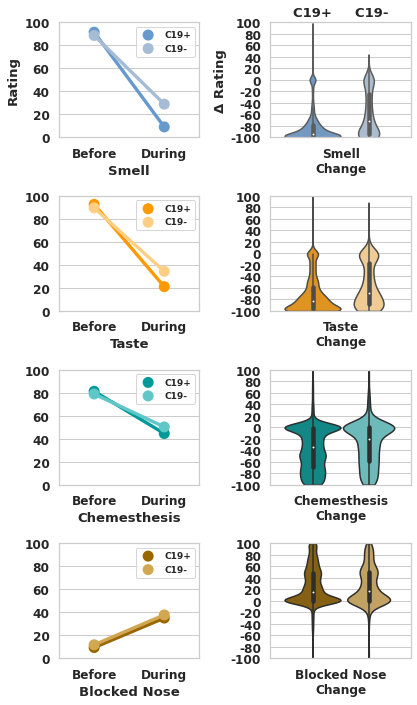

In [5]:
figures.CONTEXT = 2
figures.senses_summary(df, s, senses, left=["before", "during"], right=["change"])

### Figure 3

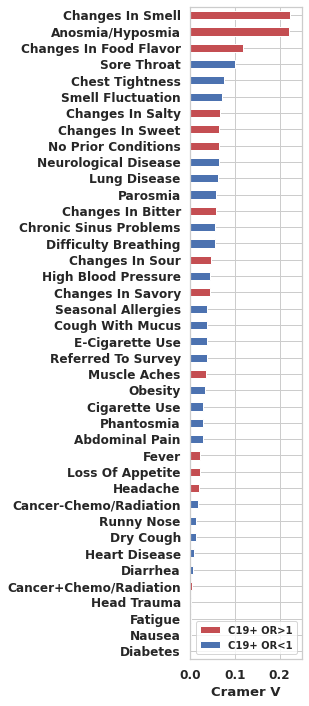

In [6]:
figures.CONTEXT = 3
figures.cramer_vs(df, classes)

In [7]:
# Single feature models
single_feature_aucs = get_tuple_feature_aucs(
    lrcv, X, y, 1, sample_weight=sample_weight, nicify_=False
)
single_feature_aucs.head(5)

,ROC AUC
Symptom set,
Smell_during_illness,0.709
Smell_change_illness,0.684
Taste_change_illness,0.635
Taste_during_illness,0.630
Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before,0.620


In [8]:
single_feature_aucs_w_smell = get_tuple_feature_aucs(
    lrcv,
    X,
    y,
    1,
    sample_weight=sample_weight,
    nicify_=False,
    add_to=["Smell_during_illness"],
)

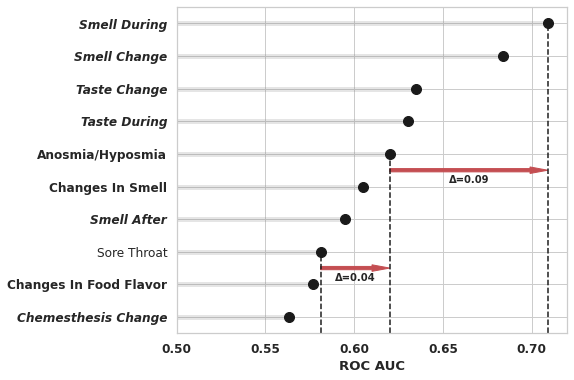

In [9]:
figures.single_auc(single_feature_aucs, classes, figsize=(7, 6))
plt.xticks(np.arange(0.5, 0.75, 0.05));

[Text(0, 0, '0'), Text(0, 0, '0.025')]

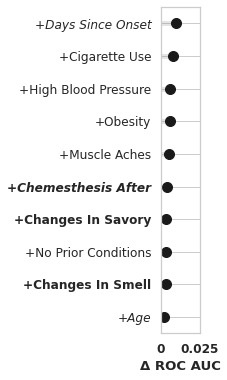

In [10]:
figures.single_auc_delta(
    single_feature_aucs_w_smell,
    single_feature_aucs.values[0],
    classes,
    figsize=(0.7, 6),
)
plt.gca().set_xticklabels([0, 0.025])

Smell: Sens50 = 0.845, Spec50 = 0.749
DSO: Sens50 = 0.537, Spec50 = 0.533
Smell+DSO: Sens50 = 0.813, Spec50 = 0.793
Fever+Cough+Dyspnea(CDC3): Sens50 = 0.547, Spec50 = 0.539
Smell+DSO+CDC3: Sens50 = 0.814, Spec50 = 0.762
Full: Sens50 = 0.822, Spec50 = 0.77


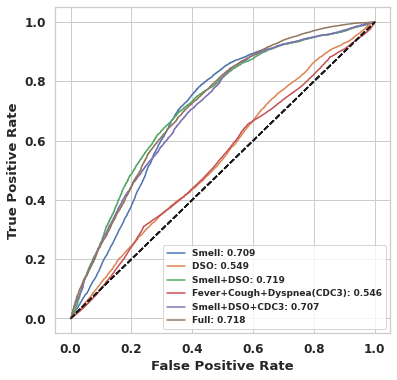

In [11]:
classes["features"].update(
    {
        "Smell": ["Smell_during_illness"],
        "DSO": ["Days_since_onset"],
        "Full": features,
        "Fever+Cough+Dyspnea(CDC3)": classes["features"]["CDC3"],
    }
)
class_sets = [
    ("Smell",),
    ("DSO",),
    ("Smell", "DSO"),
    ("Fever+Cough+Dyspnea(CDC3)",),
    ("Smell", "DSO", "CDC3"),
    ("Full",),
]
figures.all_rocs(lr, X, y, classes, class_sets, sh_split);

In [13]:
# Best model, with error bars and p-values, in natural units
tables.fit_and_coefs(
    Xu.loc[y.index].clip(0, 30), y, ["Smell_during_illness", "Days_since_onset"]
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.32223381291926506
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.2,0.05,42,0,2.1,2.4
Smell During,-0.07,0.0039,-19,2.7e-78,-0.078,-0.063
Days Since Onset,-0.015,0.0052,-2.8,0.0057,-0.024,-0.0042


In [83]:
z = tables.conf_mat_stats2(
    Xu,
    y,
    [
        ("Smell_during_illness", 30, -1),
        ("Smell_during_illness", 13, -1),
        ("Smell_during_illness", 1, -1),
        ("Smell_during_illness", 0.1, -1),
        ("Symptoms_changes_in_smell", 0.5, 1),
        ("Symptoms_fever", 0.5, 1),
        ("Symptoms_dry_cough", 0.5, 1),
        ("Symptoms_difficulty_breathing_/_shortness_of_breath", 0.5, 1),
    ],
)
z.rename(index={"Smell During < 0.1": "Total Smell Loss"})

,Sensitivity,Specificity,Odds Ratio
Feature,,,
Smell During < 30,0.91,0.34,5.44
Smell During < 13,0.85,0.51,5.68
Smell During < 1,0.51,0.75,3.13
Total Smell Loss,0.36,0.83,2.61
Changes In Smell,0.92,0.29,4.89
Fever,0.54,0.49,1.15
Dry Cough,0.52,0.46,0.92
Difficulty Breathing,0.35,0.57,0.70


In [15]:
# figures.CONTEXT = "Not used"
# figures.plot_clipped_auc(lrcv, Xu, y, "Smell_during_illness")

### Figure 4

In [16]:
# The three smell loss and recovery clusters
s["intact-smell"] = get_set(df, "Smell_change_illness > -33.3")
s["severe-smell-loss"] = get_set(df, "Smell_change_illness < -33.3")
s["recovered-smell"] = get_set(
    df, "Smell_change_illness < -33.3 & Smell_recovery_illness > 33.3"
)
s["nonrecovered-smell"] = get_set(
    df, "Smell_change_illness < -33.3 & Smell_recovery_illness <= 33.3"
)

three_clusters = {
    "Intact\nSmell": s["recovery-data"] & s["intact-smell"],
    "Recovered\nSmell": s["recovery-data"] & s["recovered-smell"],
    "Persistent\nSmell Loss": s["recovery-data"] & s["nonrecovered-smell"],
}

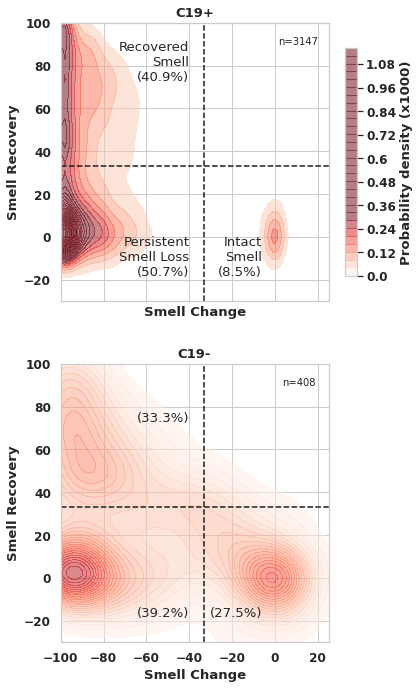

In [17]:
figures.CONTEXT = 4
figures.contour_plots(
    df, s, "Smell_change_illness", "Smell_recovery_illness", three_clusters
)

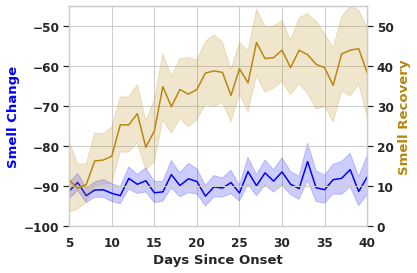

In [19]:
figures.CONTEXT = 4
figures.feature_vs_days(
    df, s, restrict=s["severe-smell-loss"] & s["lab-covid"], features=["Smell_change_illness", "Smell_recovery_illness"]
)

In [20]:
tables.big_table(df, s, three_clusters, sem=False)

In [21]:
# figures.odds_ratios_cutoff(
#    df,
#    diagnoses,
#    "Smell_during_illness",
#    binary="Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before",
#    xlim=(1, 6),
# )

In [22]:
# figures.CONTEXT = "Not used"
# figures.which_cluster(df, classes, s, three_clusters)

### Figure 5

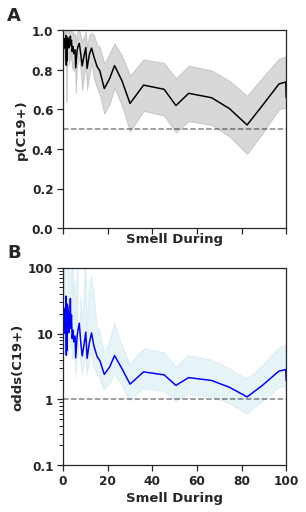

In [23]:
figures.CONTEXT = 5
figures.odds_figure(Xu, y, "Smell_during_illness")

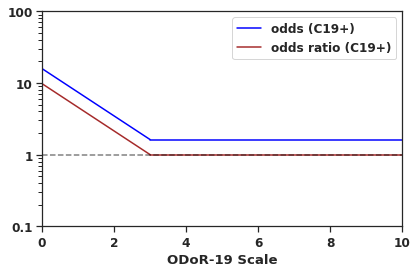

In [24]:
figures.CONTEXT = 5
figures.odds_cartoon()

## Supplement

In [25]:
# three_clusters_pos = {
#    key: three_clusters[key] & s["lab-covid"] for key in three_clusters
# }
#
# cluster_summary(df, three_clusters_pos, s, "Age")

In [26]:
# cluster_summary(df, three_clusters_pos, s, "Days_since_onset")

In [27]:
# cluster_summary(df, three_clusters_pos, s, "Onset_day")

In [28]:
# Contingency table for the three clusters vs two genders, normalize row probabilities to add to 1.
# Set normalize to 0 to make column probabilities add to 1.  Set normalize to None to show counts.
# Men are less likely to have smell loss in the first place, but somewhat more likely to regain it if it is lost
# feature_contingency(df, three_clusters_pos, "Gender", drop=["2.0", "3.0"], normalize=1)

In [29]:
# Same as above but only given smell loss
# Men still recover significantly more often than women (or just use the scale differently)
# two_clusters_pos = {
#    key: value
#    for key, value in three_clusters_pos.items()
#    if key in ["Persistent\nSmell Loss", "Recovered\nSmell"]
# }
# feature_contingency(df, two_clusters_pos, "Gender", drop=["2.0", "3.0"], normalize=1)

In [30]:
# Distractors
drop = get_matches(
    Xu,
    [
        "Test_Name",
        "Referred",
        "GCCR",
        "Changes_in_smell_i_cannot_smell_at_all_",
        "Symptoms_changes_in_smell",
        "Gender_F",
        "3.0",
        "2.0",
        "Recovery_y/n",
        "after_illness",
        "recovery_illness",
        "Smell_during",
        "Onset_day",
        "Completion_day",
    ],
)
# Restrictions
r = s["resp-recovery"] & s["recovery-data"] & s["severe-smell-loss"] & s["lab-covid"]
r = sorted(r)
# Covariates
X = Xn.loc[r].drop(drop, axis=1)
# Target
y = Xu.loc[r]["Smell_recovery_illness"] > 33.3

### Recovery Prediction Model

In [31]:
# Single feature models
lrcv = LogisticRegressionCV(
    penalty="elasticnet",
    solver="saga",
    Cs=[1],
    l1_ratios=[1],
    max_iter=10000,
    random_state=0,
    cv=sh_split,
    scoring="roc_auc",
)
sample_weight = get_weights(X, y, "balanced-by-country")
single_feature_aucs_recovery = get_tuple_feature_aucs(
    lrcv, X, y, 1, sample_weight=sample_weight
)
single_feature_aucs_recovery.head(5)

,ROC AUC
Symptom set,
Days Since Onset,0.621
Blocked Nose Change,0.541
Changes In Savory,0.538
Blocked Nose During,0.535
Age,0.530


In [32]:
# features = list(
#    chain(
#        *[
#            classes["features"][kind]
#            for kind in ["chemosensory", "typical", "history", "demographic"]
#        ]
#    )
# )

In [33]:
# X = Xn.loc[s["lab-covid"] | s["non-covid"], features]
# y = X.index.to_series().isin(s["lab-covid"])
# tables.predict_others(lr, X, Xn, y, s, classes, class_weights="balanced")

### Comparison between GCCR and YouGov

In [34]:
yg_countries = download_yougov()

In [35]:
yg_gccr_rs = compute_gccr_yougov_corr(df, s, yg_countries)

/home/rgerkin/.local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GCCR_N    3962
YG_N      8601
dtype: int64



In [37]:
# country_of_residence = pd.read_csv("country-of-residence.csv", index_col=0)
# df_ = df.join(country_of_residence, how="inner")
# df_["yg_week"] = yg_week(df_, offset=0, how="Completion_day")
# yougov = get_yougov(df_, yg_countries)
# gccr_yougov = compare_yougov(df_, yougov, s)

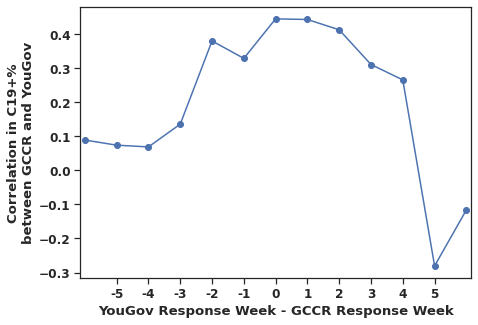

In [38]:
figures.CONTEXT = "Supplement"
figures.plot_yougov(yg_gccr_rs)

In [39]:
tables.yougov_odds_ratios()

,N,% C19+,% C19-,OR (C19+ vs C19-),OR(C19+ vs Not Tested),OR(C19- vs Not Tested),p(Smell Loss | C19+)
!!Global,109395,0.51,3,5.96,49.7,8.33,0.33
!Global,8796,0.51,3,8.19,59,9.03,0.34
Brazil,4167,0.91,5.4,8.39,33.9,4.04,0.47
Canada,5524,0.47,3.4,7.76,71.6,9.22,0.35
Denmark,5839,0.36,5.7,9.35,77.8,8.32,0.33
Finland,5927,0.32,1.9,1.85,27.8,15.1,0.21
France,9820,0.46,1.7,7,57.9,8.27,0.29
Germany,9468,0.49,2.1,4.56,94.2,20.7,0.37
Italy,9790,0.33,2.8,9.17,50.8,5.54,0.22
Mexico,5840,0.24,3.5,8.91,27.6,3.1,0.21


### Details of Chemosensory Recovery

Smell (after): C19+ = 39.5 +/- 34.7; C19- = 51.9 +/- 35.3; p=1.82e-11
Smell (recovery): C19+ = 30.2 +/- 35.6; C19- = 24.6 +/- 31.9; p=0.000232
Taste (after): C19+ = 49.8 +/- 33.6; C19- = 57.2 +/- 33.7; p=1.48e-05
Taste (recovery): C19+ = 28.3 +/- 34.6; C19- = 22.7 +/- 35.2; p=0.00153
Chemesthesis (after): C19+ = 62.4 +/- 29.1; C19- = 62.8 +/- 28.7; p=0.425
Chemesthesis (recovery): C19+ = 17.3 +/- 30.9; C19- = 15 +/- 31.3; p=0.0941
Blocked Nose (after): C19+ = 18.8 +/- 24.5; C19- = 22.8 +/- 26; p=0.000491
Blocked Nose (recovery): C19+ = -16 +/- 27.8; C19- = -14.4 +/- 27.3; p=0.074


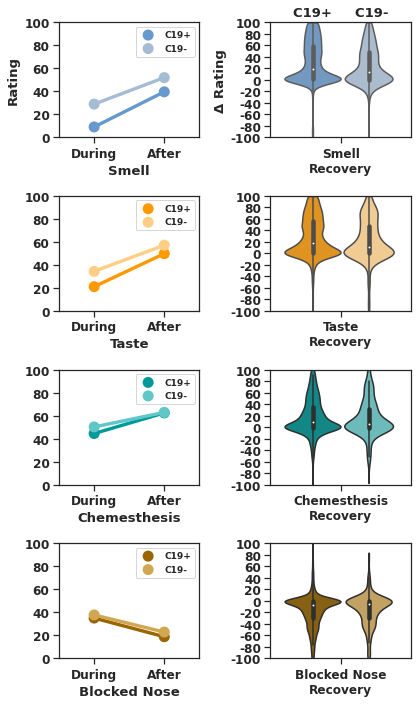

In [40]:
# Without filtering out those who have not yet recovered from respiratory illness
figures.CONTEXT = "Supplement"
figures.senses_summary(df, s, senses, left=["during", "after"], right=["recovery"])

Smell (after): C19+ = 39.8 +/- 34.7; C19- = 52.2 +/- 35.2; p=2.77e-11
Smell (recovery): C19+ = 30.5 +/- 35.7; C19- = 24.6 +/- 31.9; p=0.000215
Taste (after): C19+ = 50.1 +/- 33.5; C19- = 57.3 +/- 33.6; p=2.59e-05
Taste (recovery): C19+ = 28.5 +/- 34.6; C19- = 22.5 +/- 35.2; p=0.000981
Chemesthesis (after): C19+ = 62.6 +/- 28.9; C19- = 62.9 +/- 28.6; p=0.466
Chemesthesis (recovery): C19+ = 17.3 +/- 30.9; C19- = 15 +/- 30.7; p=0.0729
Blocked Nose (after): C19+ = 18.8 +/- 24.6; C19- = 22.6 +/- 25.9; p=0.00132
Blocked Nose (recovery): C19+ = -16.2 +/- 28; C19- = -14.9 +/- 27.3; p=0.11


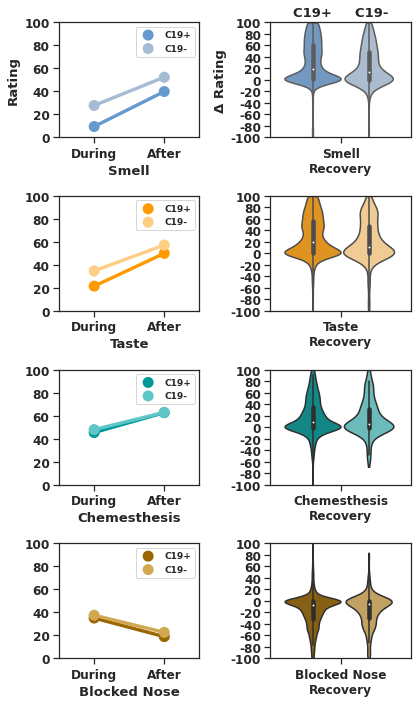

In [41]:
# With filtering out those who have not yet recovered from respiratory illness
figures.CONTEXT = "Supplement"
restrict = s["resp-recovery"] & s["recovery-data"] & (s["lab-covid"] | s['non-covid'])
figures.senses_summary(df.loc[restrict], s, senses, left=["during", "after"], right=["recovery"])

### Entropy and Mutual Information in Survey Questions

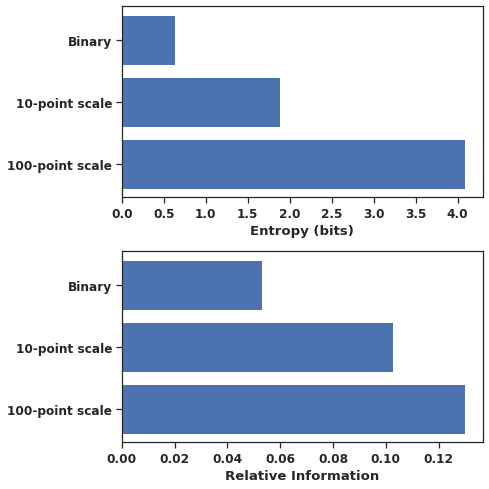

In [42]:
figures.CONTEXT = "Supplement"
figures.plot_entropy(
    df,
    "Smell_during_illness",
    binary="Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before",
)

In [43]:
z = df['Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before'].value_counts(normalize=True)
n = df['Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before'].dropna().count()
p = z[1.0]
p_high = p+2*np.sqrt(p*(1-p)/n)
p_low = p-2*np.sqrt(p*(1-p)/n)
entropy(z, base=2), entropy([p_high, 1-p_high], base=2), entropy([p_low, 1-p_low], base=2)

(0.6378647826865977, 0.6237425859731514, 0.6516204427894479)

In [44]:
def std_entropy(p, n):
    z = 0
    h = entropy(p, base=2)
    for pi in p:
        z += pi*np.log2(pi)**2 - h**2
    return np.sqrt(z/n)

0.6378+ 2*std_entropy(z, n)

0.6473337114341029

### Lab test C19 vs Clinical C19

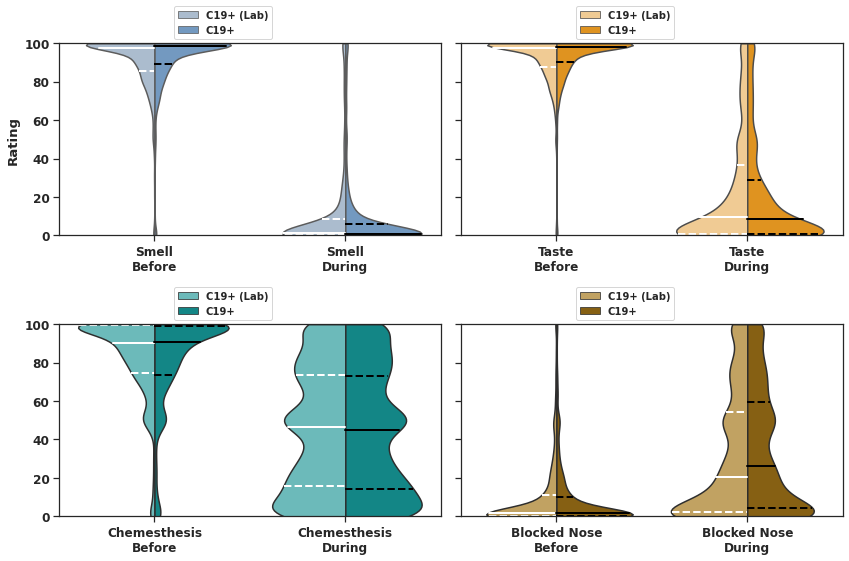

In [45]:
figures.CONTEXT = "Supplement"
figures.lab_vs_clinical(df, s, senses)

In [46]:
tables.lab_vs_clinical(df, diagnoses, senses)

,Smell Change,Taste Change,Chemesthesis Change,Blocked Nose Change
Δ,-4.4,-3.4,0.37,3.9
σ,0,0,37,33
seΔ,-0.048,-0.037,0.0041,0.043
D,-0.15,-0.1,0.01,0.12
p,2.7e-13,2e-06,0.38,4e-09


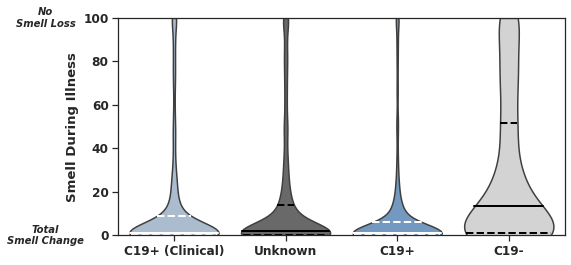

In [47]:
figures.CONTEXT = "Supplement"
figures.one_sense_all_diagnoses(df, "Smell")

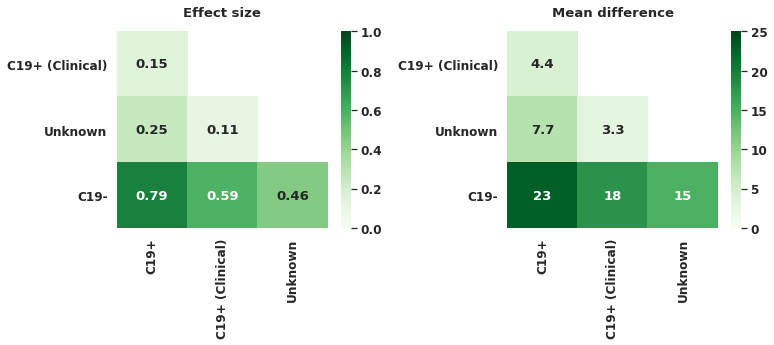

In [48]:
figures.CONTEXT = "Supplement"
figures.effect_size_comparison(df, diagnoses, "Smell", "change")

### Orthogonality of Nasal Blockage

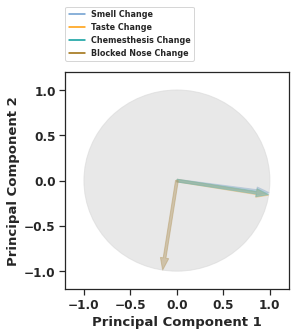

In [49]:
figures.CONTEXT = "Supplement"
figures.pc_senses(df, s, senses)

### Collider bias

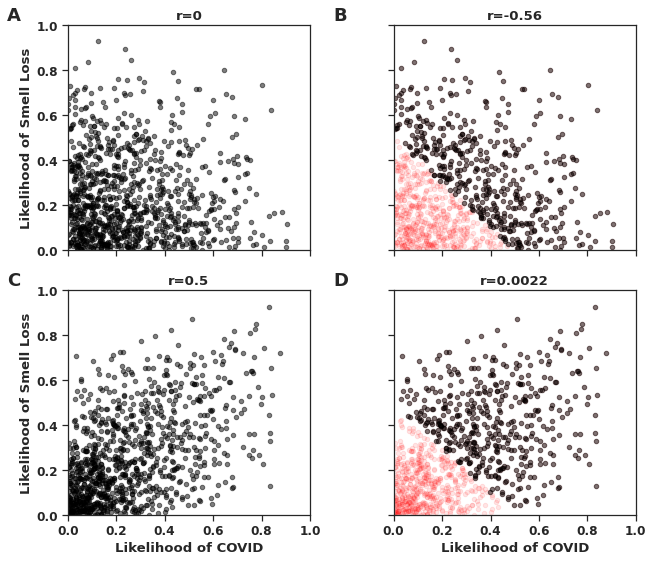

In [50]:
figures.CONTEXT = "Supplement"
figures.collider_bias()

In [51]:
# figures.CONTEXT = "Not Used"
# figures.alt_senses_summary(df, s, senses)

In [52]:
# tables.all_compare(df, diagnoses, "Chemesthesis", "change")

In [53]:
# tables.all_compare(df, diagnoses, "Chemesthesis", "recovery")

In [54]:
# figures.CONTEXT = "Unused"
# figures.effect_size_comparison(df, diagnoses, "Smell", "recovery")

In [55]:
# tables.all_compare(df, diagnoses, "Smell", "during")

In [56]:
# tables.all_compare(df, diagnoses, "Taste", "after")

In [57]:
# tables.all_compare(df, diagnoses, "Taste", "recovery")

In [58]:
# figures.CONTEXT = "Supplement"
# figures.numeric_by_categorical(
#    df, s, "Smell_during_illness", "Gender", restrict=(s["female"] | s["male"])
# )

In [59]:
# figures.CONTEXT = "Supplement"
# figures.numeric_by_status(df, s, "Age")

In [60]:
# figures.CONTEXT = "Supplement"
# figures.numeric_by_status_split(
#    df, s, "Age", "Gender", restrict=(s["male"] | s["female"])
# )

In [61]:
# tranche_compare(clf, X, y, s)

In [62]:
# figures.CONTEXT = "Supplement"
# figures.downsample_auc(lrcv, X, y)

In [64]:
# figures.CONTEXT = "Not Used"
# figures.predict_young_old(df, lr, X, y, s)

In [65]:
# figures.CONTEXT = "Not used"
# figures.numeric_by_status_split(
#    df, s, "Chemesthesis_change_illness", "Gender", restrict=(s["male"] | s["female"])
# )

In [66]:
# double_feature_aucs = get_tuple_feature_aucs(lrcv, X, y, 2, sample_weight=None)
# double_feature_aucs.head(15)

In [67]:
# figures.plot_double_features(double_features)

In [68]:
# figures.old_summary(Xu, s)

In [69]:
# figures.chem_and_block(df, s)

In [70]:
# figures.CONTEXT = "Supplement"
# figures.nmf_cluster(Xn, 3, classes)

In [71]:
# figures.draw_ontology(df, classes["features"])

In [72]:
# figures.CONTEXT = "Supplement"
# three_features = ["Symptoms_changes_in_smell", "Symptoms_dry_cough", "Symptoms_fever"]
# venn_covid(Xu, s["lab-covid"], three_features, label="C19+ (Lab)")

In [73]:
# figures.CONTEXT = "Supplement"
# venn_covid(Xu, s["non-covid"], three_features, label="C19- (Lab)")

In [74]:
# Signficant but small effect size.  Ignore.
# df["Did_smell_recover"] = df["Smell_recovery_illness"] > 33.3
# chem_block_categories = {
#    key: value for key, value in s.items() if "chem" in key or "block" in key
# }
# feature_contingency(df, chem_block_categories, "Did_smell_recover", normalize=1)

In [75]:
# df["Has_chemesthesis_change"] = df["Chemesthesis_change_illness"] < -50
# feature_contingency(df, three_clusters, "Has_chemesthesis_change", normalize=1)

In [76]:
# df["Has_chemesthesis_change"] = df["Chemesthesis_change_illness"] < -50
# feature_contingency(df, two_clusters_pos, "Has_chemesthesis_change", normalize=1)

In [77]:
# figures.CONTEXT = "Not used"
# figures.chem_and_block(df, s)

In [78]:
# figures.CONTEXT = "Supplement"
# figures.age_and_gender(df, s, three_clusters)

In [79]:
finish = time.time()
print("Notebook took %d seconds to execute" % (finish - start))

Notebook took 584 seconds to execute
